In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import torch.optim as optim
from IPython.core.debugger import set_trace
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
      
print(device)

GPU is available
cuda


In [3]:
base_csv = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Analysing sentiment

### Tokenization

In [4]:
stop_words = list(set(stopwords.words('english')))

In [5]:
def preprocess_string(s):
    s = s.lower()
    s = ' '.join([word for word in s.split() if word not in stop_words])
    # replace <br /><br /> with nothing
    s = re.sub('<[^>]+>', '', s)
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", ' ', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", ' ', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    
    # remove single characters
    s = ' '.join(list(filter(lambda x: len(x)!=1, s.split())))
    

    return s

In [6]:
df.loc[:, 'review'] = df.loc[:, 'review'].apply(preprocess_string)

In [7]:
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,positive
1,wonderful little production the filming techni...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there family little boy jake thinks ...,negative
4,petter mattei love time money visually stunnin...,positive


In [8]:
complete = ' '.join(df['review'].tolist()).split()
counter = Counter(complete)
# words like could, would could be removed.
most_occur = counter.most_common(4)


In [9]:
counter.most_common(10)

[('movie', 87935),
 ('film', 79675),
 ('one', 53585),
 ('like', 40160),
 ('it', 29982),
 ('good', 29737),
 ('the', 28864),
 ('time', 25099),
 ('even', 24856),
 ('would', 24599)]

In [10]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


In [11]:
x_train[1]

'there enough star power house spirits create another galaxy yet final product pretty debatable film messages noble think perhaps would agree them liberal democracy good violent fascist regime bad open mindedness good racism bad etc unfortunately we re battered head toe these much subtlety used ve described them ultimately left watching noble people without flaws squaring nasty cretins redeeming qualities radiates suspense badly orchestrated pro wrestling match jeremy irons plays patron man many contradictions meryl streep gifted bride glenn close sister law camera stays folks movie tends move quite enjoyable unfortunately house spirits engages simply way many subplots characters pop picture like shooting gallery targets get know them hence get care them result boredom if bille august director screenwriter from isabel allende book either lengthened film snipped characters film might worked completely stands nice try nice messages bonecrushing yawnfest not recommended'

In [12]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:2000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [13]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

In [14]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 2000


### Analysing review length

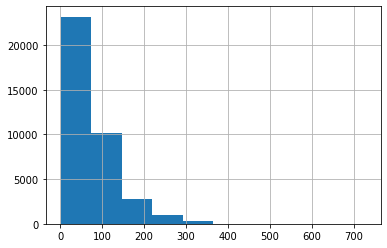

count    37500.000000
mean        80.944400
std         57.117169
min          2.000000
25%         46.000000
50%         62.000000
75%         98.000000
max        728.000000
dtype: float64

In [15]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [16]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            #features[ii, -len(review):] = np.array(review)[:seq_len]
            features[ii, :len(review)] = np.array(review)[:seq_len]
    return features

In [17]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = torch.tensor(padding_(x_train,200))
x_test_pad = torch.tensor(padding_(x_test,200))
x_train_pad.shape, x_test_pad.shape

(torch.Size([37500, 200]), torch.Size([12500, 200]))

In [18]:
x_train_pad[0]

tensor([  40, 1046,    2,  150,  227,   47,  774, 1045,  692,  736,  151,  328,
         375,  172,    1,  212,  532,  274, 1902,  115,  204,  396,   51, 1221,
         379, 1048, 1107,   88,  177, 1423,  332,  771, 1118,  501,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

### Model

In [19]:
def get_masks(padded):
    B, T = padded.shape
    mask = torch.eq(padded, 0).to(torch.float32)
    mask = mask * -1e9
    masked_reshape = mask.reshape(B, 1, T)
    return masked_reshape

train_mask = get_masks(x_train_pad)
val_mask = get_masks(x_test_pad)
print(train_mask.shape, val_mask.shape)

torch.Size([37500, 1, 200]) torch.Size([12500, 1, 200])


In [20]:
def get_angle(timesteps, dim):
    k = np.arange(dim)[np.newaxis, :]
    i = k // 2

    positions = np.arange(timesteps)[:, np.newaxis]
    angles = positions / (10000 ** (2*i/dim))

    return angles

def get_positional_embeddings(angles):
    angles[:, 0::2] = np.sin(angles[:, 0::2])
    angles[:, 1::2] = np.cos(angles[:, 1::2])

    return torch.tensor(angles, dtype=torch.float32)

In [21]:
class Embedding(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        self.embedding_layer = nn.Embedding(n_vocab, n_embed)
        
    def forward(self, x):
        return self.embedding_layer(x)

In [22]:
class Head(nn.Module):
    def __init__(self, head_size=16):
        super().__init__()
        self.query = nn.Linear(n_embed, head_size)
        self.key = nn.Linear(n_embed, head_size)
        self.value = nn.Linear(n_embed, head_size)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x, mask):
        B, T, C = x.shape
        
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        
        wei = query @ key.transpose(-2, -1)
        
        if mask is not None:
            wei = wei + mask
        
        wei = self.softmax(wei)
        out = wei @ value # (B, T, head_size)
        
        return out

In [23]:
class Encoder(nn.Module):
    def __init__(self, n_vocab, n_embed, timesteps, head_size, output):
        super().__init__() # What happens if I pass the class name in super?
        self.embedding = Embedding(n_vocab, n_embed)
        self.sa = Head(head_size)
        self.avgpool = nn.AvgPool1d(timesteps)
        self.inter1_layer = nn.Linear(head_size, head_size)
        self.output = nn.Linear(head_size, output)
        
    def forward(self, x, mask, positional_encoding):
        B, T = x.shape 
        #set_trace()
        embedding = self.embedding(x) + positional_encoding # (B, timesteps, n_embed)
        sa_out = self.sa(embedding, mask) # (B, timesteps, head_size)
        averaged = self.avgpool(sa_out.permute(0, 2, 1)) # (B, head_size, 1)
        inter1 = self.inter1_layer(averaged.view(B, -1)) # (B, head_size) @ (head_size, head_size) --> (B, headsize)
        output = self.output(inter1) # (B, head_size) @ (head_size, output) --> (B, output)
        
        return output

In [24]:
def train_epoch(x_batch, mask, y_batch, positional_encoding):
    optimizer.zero_grad()
    output = model(x_batch, mask, positional_encoding)
    #set_trace()
    output = nn.Sigmoid()(output)
    
    loss = loss_function(output.view(-1), y_batch.view(-1))
    
    correct = 0
    correct += ((output.view(-1) > 0.5).float() == y_batch).float().sum()
    accuracy = correct / y_batch.shape[0]

    loss.backward()
    optimizer.step()
    
    return loss, accuracy

In [25]:
n_embed = 32
timesteps = x_train_pad.shape[-1]
batch_size = 256
batch_per_epoch = x_train_pad.shape[0] // batch_size

train_padded, train_y = x_train_pad.to(device).long(), torch.tensor(y_train, dtype=torch.float).to(device)
val_padded, val_y = x_test_pad.to(device).long(), torch.tensor(y_test, dtype=torch.float).to(device) 
train_mask, val_mask = train_mask.to(device), val_mask.to(device)
train_positional_encoding = get_positional_embeddings(get_angle(timesteps, n_embed)).to(device)
val_positional_encoding = get_positional_embeddings(get_angle(val_padded.shape[-1], n_embed)).to(device)
print('Shape of encodings are', train_positional_encoding.shape, val_positional_encoding.shape)


model = Encoder(len(vocab)+1, n_embed, timesteps, head_size=n_embed, output=1).to(device)

loss_function = nn.BCELoss()
#loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Shape of encodings are torch.Size([200, 32]) torch.Size([200, 32])


In [26]:
def calculate_accuracy(outputs, labels):
    correct = 0
    #correct += (torch.argmax(F.softmax(outputs, dim=-1), dim=-1) == labels).float().sum()
    correct += ((outputs.view(-1) > 0.5).float() == labels).float().sum()
    return correct / labels.shape[0]

In [27]:
for epoch in range(0, 20):
    train_loss, val_loss = 0, 0
    training_accuracy = 0
    for i in range(batch_per_epoch):
        start = i * batch_size
        x_batch, y_batch, mask = train_padded[start:start+batch_size], train_y[start:start+batch_size], train_mask[start:start+batch_size]
#         x_batch, y_batch, mask = x_batch.to(device).long(), y_batch.to(device).long(), mask.to(device).long()

        model.train(True)
    
        loss, accuracy = train_epoch(x_batch, mask, y_batch, train_positional_encoding)
        train_loss += loss
        training_accuracy += accuracy
        
    print(f'Epoch {epoch} Loss: {train_loss / (i+1)}')
    print(f'Accuracy at Epoch {epoch} is {training_accuracy / (batch_per_epoch)}')
    
    model.eval()
    with torch.no_grad():
        output_val = model(val_padded, val_mask, val_positional_encoding)
        output_val = nn.Sigmoid()(output_val)
        
        loss_val = loss_function(output_val.view(-1), val_y.view(-1))
        
        accuracy = calculate_accuracy(output_val, val_y)
        
        print(f'Epoch {epoch} Val loss: {loss_val}')
        print(f'Accuracy at Epoch {epoch} is {accuracy}')
        
    print()

Epoch 0 Loss: 0.6499533653259277
Accuracy at Epoch 0 is 0.6137896180152893
Epoch 0 Val loss: 0.5950494408607483
Accuracy at Epoch 0 is 0.6832799911499023

Epoch 1 Loss: 0.5367849469184875
Accuracy at Epoch 1 is 0.7279537320137024
Epoch 1 Val loss: 0.4817543625831604
Accuracy at Epoch 1 is 0.7683199644088745

Epoch 2 Loss: 0.4287336468696594
Accuracy at Epoch 2 is 0.8017711639404297
Epoch 2 Val loss: 0.4163311719894409
Accuracy at Epoch 2 is 0.8076799511909485

Epoch 3 Loss: 0.37959668040275574
Accuracy at Epoch 3 is 0.8302386403083801
Epoch 3 Val loss: 0.3874422311782837
Accuracy at Epoch 3 is 0.8245599865913391

Epoch 4 Loss: 0.35338300466537476
Accuracy at Epoch 4 is 0.8446061611175537
Epoch 4 Val loss: 0.3690919578075409
Accuracy at Epoch 4 is 0.8362399935722351

Epoch 5 Loss: 0.3342018723487854
Accuracy at Epoch 5 is 0.8545858263969421
Epoch 5 Val loss: 0.3562313914299011
Accuracy at Epoch 5 is 0.8459199666976929

Epoch 6 Loss: 0.3192940950393677
Accuracy at Epoch 6 is 0.8622912764

### Training

In [60]:
imp = list()

def hook_function(module, input, output):
    #set_trace()
    if not model.training:
        #set_trace()
        imp.append(output[0].tolist())

In [29]:
#handle.remove()
for name, layer in model.named_children():
    if name == 'sa':
        for sa_name, sa_layer in layer.named_children():
            if sa_name == 'softmax':
                print(sa_name)
                handle = sa_layer.register_forward_hook(hook_function)

softmax


In [32]:
def predict_text(text):
    #set_trace()
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                     if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(padding_(word_seq,200))
    inputs = pad.to(device)
    test_mask = get_masks(inputs).to(device)
    batch_size = 1
    model.eval()
    output = model(inputs, test_mask, train_positional_encoding)
    output = nn.Sigmoid()(output)
    return output.item()

In [36]:
base_df = pd.read_csv(base_csv)
base_df.shape

(50000, 2)

In [41]:
base_df.sample(5)

,review,sentiment
43606,Joline (Heather Graham) married Carl (Luke Wil...,positive
42643,"If it wasn't for Colin Firth, the movie would ...",negative
33415,This great movie has failed to register a high...,positive
28902,I remember watching this late at night on blac...,positive
12755,The production year says it all. The movie is ...,negative


In [63]:
base_df.loc[index, 'review']

'I used to have a fascination with the cartoon back in college when it was being made. It had much the charm of "Get Smart". While it admittedly had its faults, it was rather enjoyable.<br /><br />Naturally I was very interested in seeing the film version. That was before I saw it. Afterwords I wished it had never been made.<br /><br />Besides being miscast all around (who on Earth though Broderick was even close to the role?) it just didn\'t make the grade.<br /><br />The effects were reasonable and perhaps the ONLY thing I liked about the movie; seeing a live-action version of the gadgets in action! What was missing was a story and treatment which made it funny or charming or interesting.<br /><br />The original was a wacky cartoon with a very lighthearted attitude. It was FUN. The motion picture became murky and took itself FAR too seriously. If it had seriously had a great plot or went crazy enough to make it seem like a "cartoon on film" it might have been enjoyable.<br /><br />As

In [61]:
# remember to reset the list imp after every test prediction
# 13000, 14000, 15000, 15100, 33415
index = 15100 
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')
imp = list()

used fascination cartoon back college made much charm get smart admittedly faults rather enjoyable naturally interested seeing film version saw it afterwords wished never made besides miscast around who earth though broderick even close role make grade the effects reasonable perhaps thing liked movie seeing live action version gadgets action missing story treatment made funny charming interesting the original wacky cartoon lighthearted attitude fun motion picture became murky took far seriously seriously great plot went crazy enough make seem like cartoon film might enjoyable as exists deserve considered part gadget legacy
Actual sentiment is  : negative
Predicted sentiment is positive with a probability of 0.7185630798339844


In [64]:
attn_imp = np.sum(np.array(imp)[0], axis=0)
cleaned_words = ' '.join([word for word in df.loc[index, 'review'].split() if preprocess_string(word) in vocab.keys()])
#colors = attn_imp * (255/np.max(attn_imp))
maxi = np.max(attn_imp); mini = np.min(attn_imp)
max_val, min_val = 250, 0
colors = min_val + (max_val - min_val) * (attn_imp - mini) / (maxi - mini)

for color, word in zip(colors.tolist(), cleaned_words.split()):
    if int(color) > 0:
        if int(color) < 30:
            r, g, b = 255, 255, 255
            print(f'\033[48;2;{int(r)};{g};{b}m{word}\033', end=' ')
        else:
            r, g, b = int(color), 0, 0
            print(f'\033[48;2;{r};{g};{b}m\033[1m\033[97m{word}\033[0m', end=' ')
            #print(f'\033[48;2;{r};{g};{b}m\033[97m{word}\033[0m', end=' ')

used cartoon back college made much charm get smart rather enjoyable naturally interested seeing film version saw never made besides around earth though even close role make grade effects perhaps thing liked movie seeing live action version action missing story made funny charming interesting original cartoon attitude fun motion picture became took far seriously seriously great plot went crazy enough make seem like cartoon film might enjoyable deserve considered part 

In [ ]:
for r in list(range(160, 255, 5)):
    #print(f'\033[48;5;{r};1;1mthis\033')
    #print(f'\033[48;5;{r}mthis\033')
    gb = 40
    print(f'\033[48;2;{r};{gb};{gb}mthis {r}\033')

In [ ]:
def scale_array(array, min_value, max_value):
    min_array_value = min(array)
    max_array_value = max(array)
    scaled_array = []
    print(min_value, max_value)
    print(min_array_value, max_array_value)
    scaled_value = min_value + (max_value - min_value) * (array - min_array_value) / (max_array_value - min_array_value)
#     for value in array:
#         scaled_value = min_value + (max_value - min_value) * (value - min_array_value) / (max_array_value - min_array_value)
#         scaled_array.append(scaled_value)

    return scaled_value

# Example usage
array = attn_imp
min_value = 0
max_value = 255

scaled_array = scale_array(array, min_value, max_value)
print(scaled_array)  # Output: [0.0, 25.0, 50.0, 75.0, 100.0]
